Search Efficient + Spline (Example)
====

**Conexión por SSH**

In [1]:
import ibex
ssh = ibex.connect("158.251.88.197")

login: iaraya
pass: ········


In [ ]:
#ibex.get_instances()

**Interpolación usando spline y search_efficient**

['-273.999999847566 154.253710341865 4.99999999900001 \n', '1.00000000000001 \n', '4.99999999969575 \n', '0 \n', '5 \n', '8.84611272565004 \n', '0.0362020000000001']
['-42.4189719344653 4.0001509618088 0.99131230088677 \n', '1.00868770011324 \n', '1.00000000025137 \n', '0 \n', '1 \n', '8.40055529542916e-05 \n', '0.0315560000000001']
inital box: [-273.999999847566, -42.4189719344653] [4.0001509618088, 154.253710341865]
['-273.907854739876 75.884785339615 4.99999999900001 \n', '1.00000000000001 \n', '4.98846522986927 \n', '0 \n', '5 \n', '5.50101840380516e-07 \n', '0.0365930000000001']
['-250.745456236619 42.659999938599 4.99999999900001 \n', '1.00000000000001 \n', '3.95727178098664 \n', '0 \n', '1 \n', '2.40846574284249e-06 \n', '0.0444520000000001']
['-227.691925952848 26.9724130799526 4.90259147984171 \n', '0.967530493613901 \n', '1.00044720283647 \n', '0 \n', '1 \n', '9.99999638651162e-10 \n', '0.0306430000000001']
['-204.484186458317 25.2741384093639 4.73716118861918 \n', '0.9123870

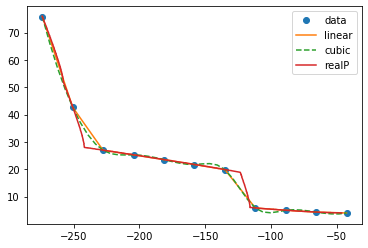

In [2]:
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

instance = "osy.txt"
npoints = 11
prec_se = 1e-2 #precisión para search_efficient
prec = 1e-1 #precisión para el solver

# We obtain the initial box
b1 = ibex.search_efficient(instance, [-1e8,1e8,-1e8,1e8], mode="minf1", prec=prec_se)[1]
b2 = ibex.search_efficient(instance, [-1e8,1e8,-1e8,1e8], mode="minf2", prec=prec_se)[1]
y1 = [b1[0], b2[0]]
y2 = [b2[1], b1[1]]
print("inital box:", y1,y2)


x = np.linspace(y1[0], y1[1], num=npoints, endpoint=True)
y = np.zeros(npoints)
i = 0
for a in x:
    xx, yy = ibex.search_efficient(instance, [a-10*prec_se,a+10*prec_se,y2[0],y2[1]], mode="minf2", prec=prec_se)[1]
    x[i] = xx; y[i] = yy
    i+=1
    

f = interp1d(x, y)
f2 = interp1d(x, y, kind='cubic')

xsol, ysol = ibex.solve(instance, prec=prec)

xnew = np.linspace(x[0], x[-1], num=41, endpoint=True)

#plot
plt.plot(x, y, 'o', xnew, f(xnew), '-', xnew, f2(xnew), '--', xsol, ysol, '-')
plt.legend(['data', 'linear', 'cubic', 'realP'], loc='best')
plt.show()

Búsqueda de puntos eficientes
--

**1. Cálculo del punto a interpolar**

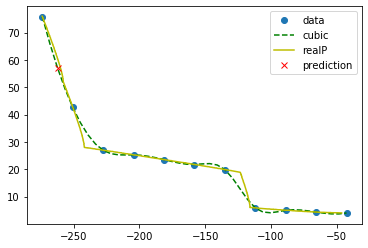

In [3]:
max_area=0;
for i in range(len(x)-1):
    area = (x[i+1]-x[i])*(y[i]-y[i+1])
    if max_area < area:
        max_area=area
        best_i = i
xmid = np.array((x[best_i]+x[best_i+1])/2) #punto a interpolar

f2 = interp1d(x, y, kind='cubic')

plt.plot(x, y, 'o', xnew, f2(xnew), 'g--', xsol, ysol, 'y-', xmid, f2(xmid), 'rx')
plt.legend(['data', 'cubic', 'realP', 'prediction'], loc='best')
plt.show()

**2. Creación de small_box**

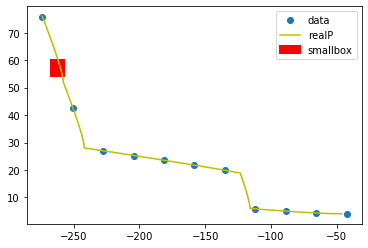

In [4]:
hy = 0.02*(y2[1]-y2[0])
hx = 0.02*(y1[1]-y1[0])

small_box = [xmid-hx, xmid+hx, f2(xmid)-hy, f2(xmid)+hy]

#plot
import matplotlib.patches as patches

# Create figure and axes
fig,ax = plt.subplots(1)

# Create a Rectangle patch
rect = patches.Rectangle((xmid-hx,f2(xmid)-hy),2*hx,2*hy,linewidth=2,edgecolor='r',facecolor='r')

# Add the patch to the Axes
ax.add_patch(rect)
plt.plot(x, y, 'o', xsol, ysol, 'y-')
plt.legend(['data', 'realP', 'smallbox'], loc='best'); plt.show()

**3. Buscando en small_box**

['-260.452061516062 57.6556694889682 4.99989700898252 1.00006565450987 2.59381357431292 0.00183842042866347 4.99275637651383 0.0328572960923825 \n', '0.113927000000001']


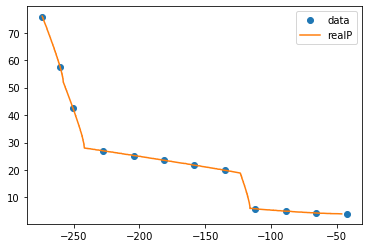

time (search efficient): 0.113927000000001


In [9]:
_temp, auxy, time =  ibex.search_efficient(instance, small_box, mode="efficient", prec=1e-1)
xx, yy = auxy

if xx==np.inf or yy==np.inf:
    print("no solution found")
else:
    x_=np.append(x,xx); x_.sort()
    y_=np.append(y,yy); y_[::-1].sort()

    plt.plot(x_, y_, 'o', xsol, ysol, '-')
    plt.legend(['data', 'realP'], loc='best')
    plt.show()
print("time (search efficient):", time)

**4. Actualizar vectores. Luego, volver a 1**

In [17]:
x=x_; y=y_